# Encoding for Neuroevolution


This notebook introduces the GENE encoding for neuroevolution and presents some results for direct and indirect encoding of the genomes.

In [1]:
import jax.random as jrd 
import jax.numpy as jnp
from jax import jit, vmap
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from run import run

import copy
from functools import partial

plt.style.use('bmh')  # fivethirtyeight


Define the _config_ object, containing all the information about a single run.

In [2]:
config_gene = {
    "evo": {
        "strategy_name": "SNES",
        "n_generations": 30,
        "population_size": 25
    },
    "net": {
        "layer_dimensions": [4, 32, 2]
    },
    "encoding": {
        "d": 3,
        "distance": "pL2",
        "type": "gene"
    },
    "problem": {
        "environnment": "CartPole-v1",
        "maximize": True
    }
}

config_direct = copy.deepcopy(config_gene)
config_direct['encoding']['type'] = "direct"

Define an utility plot function.

In [3]:
# def plot(mean, std, labels: list[str] = [""], info: str = ""):
def plot(*args, info: str = ""):
    """Simple plotting utility function"""
    plt.figure(figsize=(12, 6))
    # for m, s, label in zip(mean, std, labels):
    for m, s, label in args:
        plt.fill_between(range(len(m)), m + 0.5 * s, m - 0.5 * s, alpha=0.35)
        plt.plot(m, label=label)
    plt.xlabel('n° generations')
    plt.ylabel('fitness')
    plt.title(f'Mean fitness over generations\n{info}')
    plt.legend()
    plt.show()

Evaluate the two defined config at the beginning using the mean and standart-deviation of 10 runs.

In [4]:
    
def evaluate_bench(config: dict, rng: jrd.KeyArray = jrd.PRNGKey(0), n: int = 10):
    rng_run = jrd.split(rng, n)
    vmap_run = vmap(partial(run, config=config))
    _, logs = vmap_run(rng=rng_run)
    return {
        'fit_best': logs['log_gen_1'].mean(axis=0),
        'fit_best_std': logs['log_gen_1'].std(axis=0),
        'mean_fit': logs['log_gen_mean'].mean(axis=0),
        'mean_fit_std': logs['log_gen_std'].mean(axis=0),
    }

In [5]:
rng =jrd.PRNGKey(0)

gene_results = evaluate_bench(config_gene, rng)
direct_results = evaluate_bench(config_direct, rng)

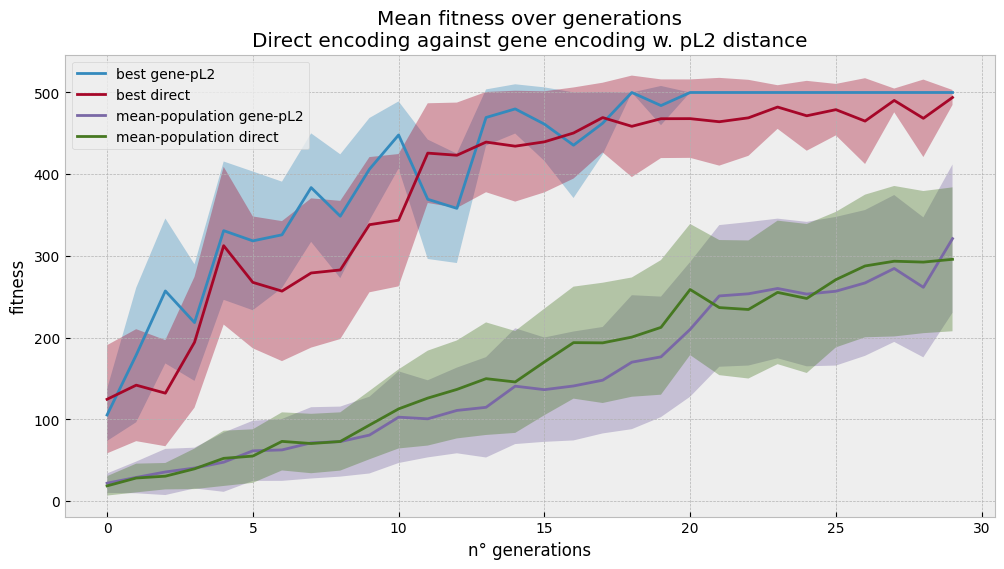

In [7]:
plot(
    (gene_results['fit_best'], gene_results['fit_best_std'], 'best gene-pL2'),
    (direct_results['fit_best'], direct_results['fit_best_std'], 'best direct'),
    (gene_results['mean_fit'], gene_results['mean_fit_std'], 'mean-population gene-pL2'),
    (direct_results['mean_fit'], direct_results['mean_fit_std'], 'mean-population direct'),
    info="Direct encoding against gene encoding w. pL2 distance"
)